In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from keras import layers, models
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.optimizers import Adam
from sklearn.metrics import f1_score
from tensorflow.keras.losses import MSE
import random

In [2]:
class CNN:
	@staticmethod
	def build(width, height, depth, classes):
		model = models.Sequential()
		inputShape = (height, width, depth)
		model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=inputShape))
		model.add(layers.MaxPooling2D(2,2))
		model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
		model.add(layers.MaxPooling2D(2,2))
		model.add(layers.Flatten())
		model.add(layers.Dense(128, activation = 'relu'))
		model.add(layers.Dense(classes, activation = 'softmax'))
		return model

In [3]:
def train_cnn(train_images, train_labels, val_images,val_labels):
    model = CNN.build(width=28, height=28, depth=1, classes=10)
    model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy']) #98.97 - adam 99.23 - rmsprop
    model.fit(train_images, train_labels, epochs = 5, batch_size = 60,validation_data=(val_images, val_labels)) 
    return model

In [4]:
def evalute_cnn(model, test_images, test_labels):
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print(f'[INFO] Loss:{test_loss:.4f} Test accuracy: {(test_acc*100):.4f}')

In [5]:
def generate_adversarial_example(input_image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = tf.sign(data_grad)
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = (input_image + (epsilon * sign_data_grad)).numpy()
    # Clip the perturbed image to be within [0, 1]
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

In [6]:
# FGSM attack
def fgsm_attack(model,image, label,epsilon):
    image = tf.cast(image, tf.float32)
    # Record gradients of the loss with respect to the input image
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    # Get the gradients of the loss with respect to the input image
    gradient = tape.gradient(loss, image)
    # Generate adversarial example using FGSM
    perturbed_image = generate_adversarial_example(image, epsilon, gradient)
    return perturbed_image

In [7]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
train_images , test_images = train_images / 255.0 , test_images / 255.0
model = train_cnn(train_images,train_labels,test_images,test_labels)
evalute_cnn(model,test_images,test_labels)




Epoch 1/5


1000/1000 [==============================] - 6s 6ms/step - loss: 0.1435 - accuracy: 0.9558 - val_loss: 0.0463 - val_accuracy: 0.9847
Epoch 2/5
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0447 - accuracy: 0.9862 - val_loss: 0.0363 - val_accuracy: 0.9871
Epoch 3/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0298 - accuracy: 0.9910 - val_loss: 0.0322 - val_accuracy: 0.9885
Epoch 4/5
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0224 - accuracy: 0.9929 - val_loss: 0.0293 - val_accuracy: 0.9910
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0276 - accuracy: 0.9913
[INFO] Loss:0.0276 Test accuracy: 99.1300


In [8]:
epsilon = 0.1
# Select a random image from the test set
pre_images = np.empty((0, 28, 28, 1))
mod_images = np.empty((0, 28, 28, 1))
mod_labels = []
count = 1000
array = random.sample(range(1, train_images.shape[0]), count)

for i in array:
    idx = np.random.randint(0, len(test_images))
    test_image = test_images[idx].reshape(1, 28, 28, 1)
    true_label = test_labels[idx]

    # Generate adversarial example
    perturbed_image = fgsm_attack(model,test_image, true_label,epsilon)
    mod_images = np.concatenate((mod_images, perturbed_image),axis=0)
    mod_labels.append(true_label)
    pre_images = np.concatenate((pre_images, test_image),axis=0)
    # Predictions before and after attack

In [9]:
modified_train_images = np.concatenate((train_images, mod_images), axis=0)
modified_train_labels = np.concatenate((train_labels, mod_labels), axis=0)
modified_test_images = np.concatenate((test_images, mod_images), axis=0)
modified_test_labels = np.concatenate((test_labels, mod_labels), axis=0)

In [10]:
model1 = train_cnn(train_images,train_labels,test_images,test_labels)
evalute_cnn(model1,modified_test_images,modified_test_labels)

Epoch 1/5
1000/1000 [==============================] - 10s 9ms/step - loss: 0.1478 - accuracy: 0.9536 - val_loss: 0.0637 - val_accuracy: 0.9782
Epoch 2/5
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0436 - accuracy: 0.9864 - val_loss: 0.0330 - val_accuracy: 0.9891
Epoch 3/5
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0297 - accuracy: 0.9910 - val_loss: 0.0283 - val_accuracy: 0.9905
Epoch 4/5
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0220 - accuracy: 0.9933 - val_loss: 0.0274 - val_accuracy: 0.9918
Epoch 5/5
344/344 [==============================] - 1s 3ms/step - loss: 0.0566 - accuracy: 0.9844
[INFO] Loss:0.0566 Test accuracy: 98.4364


In [11]:
model2 = train_cnn(modified_train_images,modified_train_labels,test_images,test_labels)
evalute_cnn(model2,modified_test_images,modified_test_labels)

Epoch 1/5
1017/1017 [==============================] - 10s 10ms/step - loss: 0.1593 - accuracy: 0.9502 - val_loss: 0.0424 - val_accuracy: 0.9861
Epoch 2/5
1017/1017 [==============================] - 9s 9ms/step - loss: 0.0481 - accuracy: 0.9850 - val_loss: 0.0333 - val_accuracy: 0.9892
Epoch 3/5
1017/1017 [==============================] - 9s 9ms/step - loss: 0.0328 - accuracy: 0.9895 - val_loss: 0.0338 - val_accuracy: 0.9896
Epoch 4/5
1017/1017 [==============================] - 9s 9ms/step - loss: 0.0246 - accuracy: 0.9927 - val_loss: 0.0265 - val_accuracy: 0.9915
Epoch 5/5
344/344 [==============================] - 1s 3ms/step - loss: 0.0286 - accuracy: 0.9907
[INFO] Loss:0.0286 Test accuracy: 99.0727


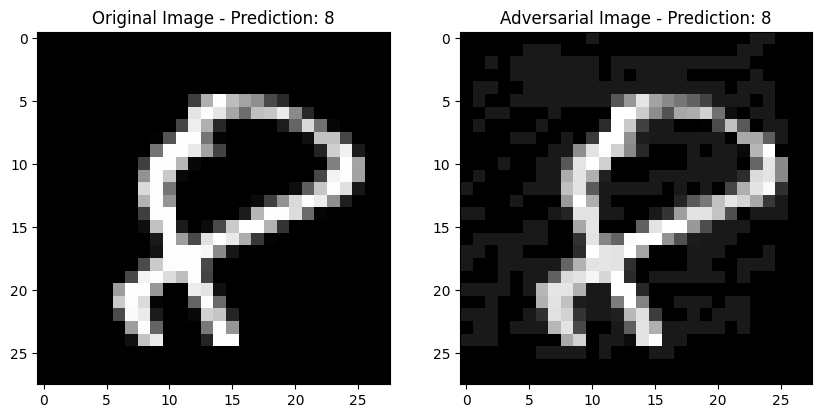

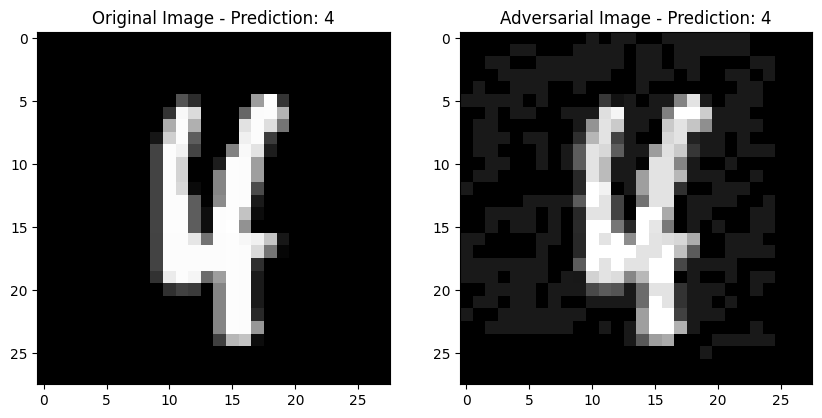

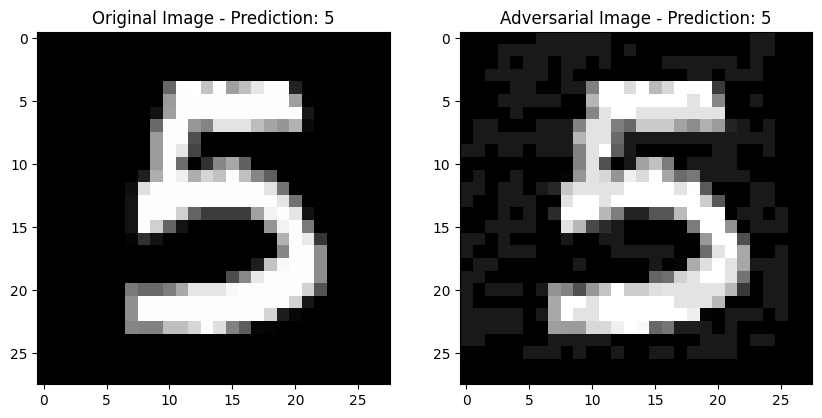

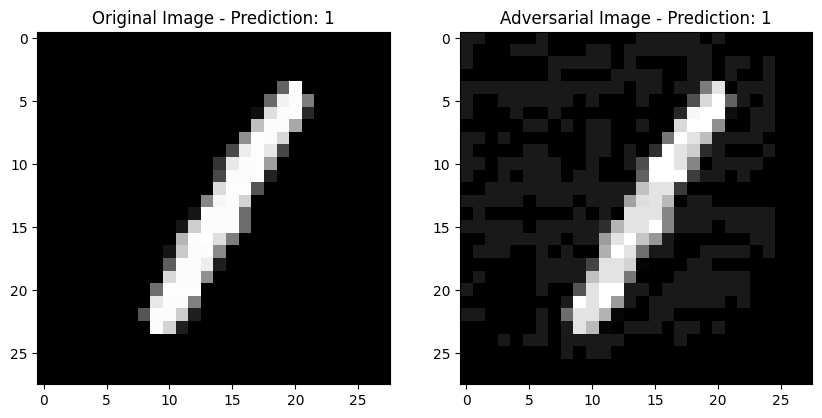

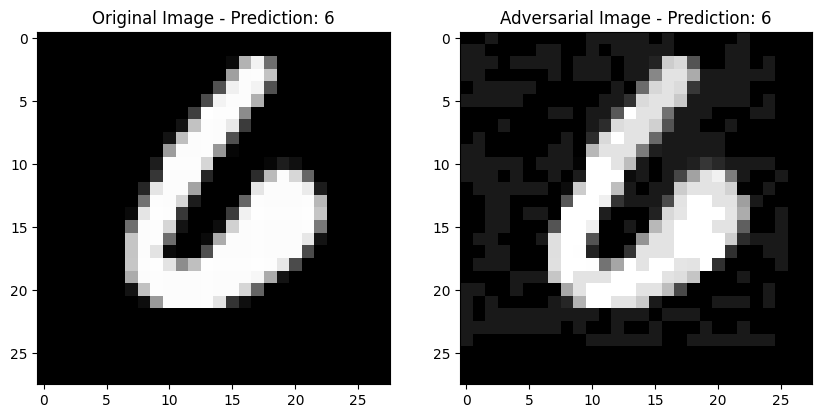

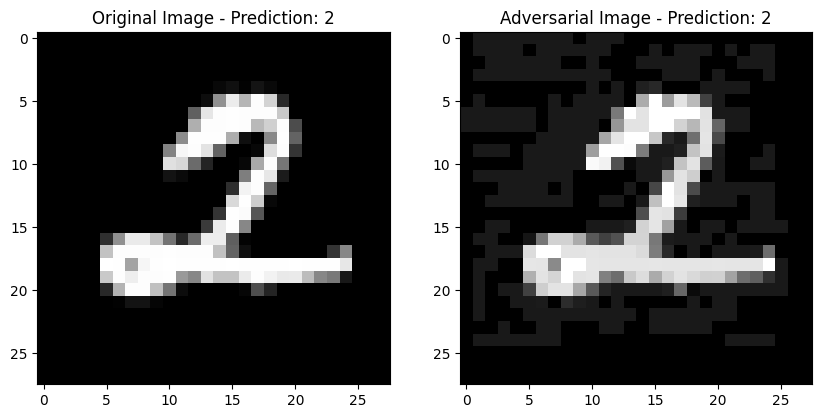

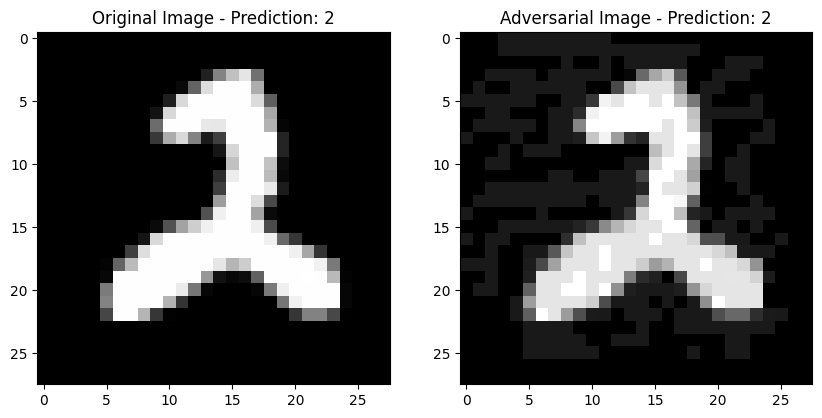

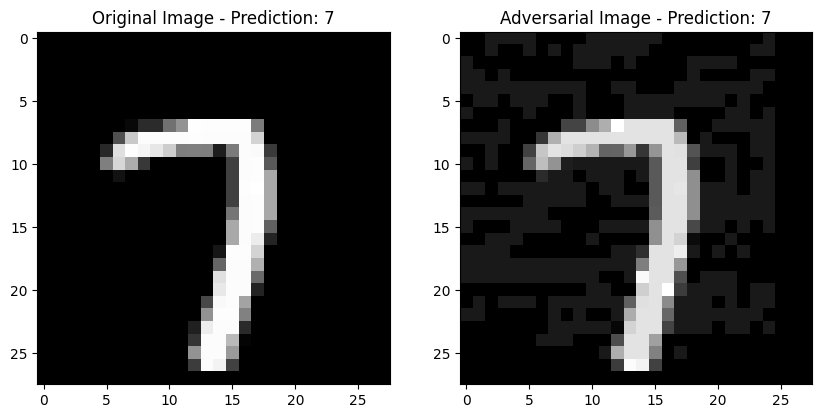

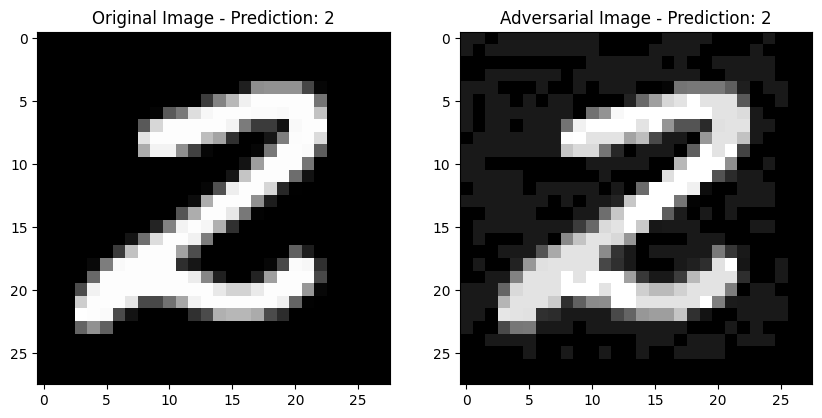

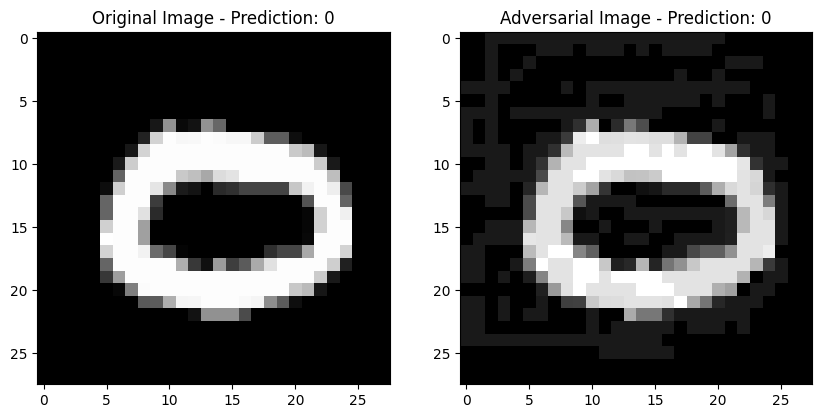

[8, 4, 5, 1, 6, 2, 2, 7, 2, 0, 9, 3, 0, 8, 8, 2, 2, 7, 6, 2, 1, 9, 9, 0, 7, 1, 7, 9, 4, 2, 6, 6, 8, 4, 7, 2, 0, 9, 4, 2, 1, 5, 4, 8, 8, 6, 6, 7, 5, 3, 8, 4, 1, 8, 6, 4, 2, 3, 9, 8, 0, 2, 2, 5, 2, 7, 1, 4, 3, 6, 8, 2, 7, 3, 4, 8, 6, 2, 1, 5, 1, 8, 0, 5, 4, 9, 8, 9, 2, 1, 9, 2, 7, 1, 8, 2, 2, 9, 5, 8, 3, 8, 0, 6, 8, 6, 6, 9, 0, 2, 1, 2, 2, 1, 7, 5, 0, 7, 0, 9, 2, 4, 0, 4, 3, 4, 4, 1, 7, 0, 6, 7, 1, 8, 5, 7, 9, 5, 4, 7, 3, 8, 3, 7, 6, 7, 2, 8, 9, 5, 6, 3, 6, 5, 4, 7, 2, 0, 5, 2, 2, 1, 5, 2, 3, 5, 8, 2, 6, 7, 0, 9, 5, 0, 5, 4, 3, 0, 1, 7, 5, 1, 6, 1, 9, 5, 2, 8, 9, 9, 7, 6, 1, 1, 6, 1, 1, 4, 9, 0, 9, 7, 9, 8, 6, 1, 4, 7, 7, 3, 7, 7, 0, 0, 3, 6, 5, 7, 0, 5, 4, 3, 1, 6, 1, 8, 7, 8, 2, 1, 2, 4, 0, 2, 5, 9, 1, 2, 0, 9, 1, 1, 8, 3, 5, 3, 9, 7, 5, 6, 5, 8, 3, 2, 7, 3, 5, 4, 3, 9, 8, 4, 7, 8, 3, 3, 2, 4, 5, 3, 6, 3, 5, 8, 4, 4, 9, 1, 4, 4, 0, 1, 8, 2, 8, 9, 3, 0, 6, 8, 0, 2, 2, 4, 6, 3, 0, 8, 4, 6, 9, 0, 5, 4, 1, 5, 5, 1, 6, 0, 2, 7, 8, 1, 8, 6, 7, 7, 5, 1, 8, 5, 0, 1, 6, 6, 1, 2, 2, 1, 7, 9, 1, 

In [12]:
for i in range(10):
    # Plot original and adversarial images
    pre_image = pre_images[i].reshape(1, 28, 28, 1)
    perturbed_image = mod_images[i].reshape(1, 28, 28, 1)
    prediction_before_attack = model(pre_image).numpy().argmax()
    prediction_after_attack = model(perturbed_image).numpy().argmax()
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(pre_image[0], cmap='gray')
    plt.title(f'Original Image - Prediction: {prediction_before_attack}')
    plt.subplot(1, 2, 2)
    plt.imshow(perturbed_image[0], cmap='gray')
    plt.title(f'Adversarial Image - Prediction: {prediction_after_attack}')
    plt.show()
# print(mod_labels)